In [1]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms, models
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
import  random as rand
import torch.utils.data
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as nnfun
import GPUtil
GPUtil.showUtilization()

print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

torch.manual_seed(42)


| ID | GPU | MEM |
------------------
|  0 |  1% | 19% |
0
0


In [2]:

transform_train = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


data = ImageFolder(root='/ssd_data/MTG Land/')

print(type(data))



<class 'torchvision.datasets.folder.ImageFolder'>


In [3]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index])

    def __len__(self):
        return len(self.dataset)



In [4]:
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [5]:
GPUtil.showUtilization()

n = len(data)
n_test = int(len(data) * .1)
n_train = n - 2 * n_test

train_data,validation_data, test_data = torch.utils.data.random_split(data, (n_train, n_test, n_test))
train_data = ApplyTransform(train_data, transform=transform_train)
validation_data = ApplyTransform(validation_data, transform=transform_test)
test_data = ApplyTransform(test_data, transform=transform_test)

GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 15% | 19% |
| ID | GPU | MEM |
------------------
|  0 | 15% | 19% |


In [6]:
training_loader = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=52, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=52, shuffle=False)

dataiter = iter(training_loader)
print(training_loader)
t, label = dataiter.next()


In [7]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image



In [8]:
class_labels =  data.classes


In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 25, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(25, 60, 5, 1, padding=2)
        self.conv3 = nn.Conv2d(60, 120, 5, 1, padding=2)
        self.fc1 = nn.Linear(27*37*120, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 5)
    def forward(self, x):
       x = nnfun.relu(self.conv1(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = nnfun.relu(self.conv2(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = nnfun.relu(self.conv3(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = self.dropout1(x)
       x = x.view(-1, 27*37*120)
       x = nnfun.relu(self.fc1(x))
       self = self.fc2(x)
       return x


In [10]:
class MTG_Image_Model(nn.Module):
    def __init__(self, input_size=3, output_size=5, convolution_layer_1=10,
                 convolution_layer_2=20, convolution_layer_3=25, convolution_layer_4=30,
                 convolution_layer_5=40, convolution_layer_6=35, linear_2=350, linear_3 = 64):
        super().__init__()
        self.linear_1 = 27*37*convolution_layer_6
        self.conv1 = nn.Conv2d(input_size, convolution_layer_1, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(convolution_layer_1, convolution_layer_2, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(convolution_layer_2, convolution_layer_3, 3, 1, padding=1)
        self.conv4 = nn.Conv2d(convolution_layer_3, convolution_layer_4, 3, 1, padding=1)
        self.conv5 = nn.Conv2d(convolution_layer_4, convolution_layer_5, 3, 1, padding=1)
        self.conv6 = nn.Conv2d(convolution_layer_5, convolution_layer_6, 3, 1, padding=1)
        self.fc1 = nn.Linear(self.linear_1, linear_2)
        self.fc2 = nn.Linear(linear_2, linear_3)
        self.fc3 = nn.Linear(linear_3, output_size)
        self.dropout_con_1 = nn.Dropout(0.2)
        self.dropout_con_2 = nn.Dropout(0.25)
        self.dropout_con_3 = nn.Dropout(0.25)
        self.dropout_con_4 = nn.Dropout(0.25)
        self.dropout_con_5= nn.Dropout(0.25)
        self.dropout_con_6 = nn.Dropout(0.25)
        self.dropout_linear_1 = nn.Dropout(0.5)
        self.dropout_linear_2 = nn.Dropout(0.5)
    def forward(self, x):
       x = nnfun.relu(self.conv1(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = self.dropout_con_1(x)
       x = nnfun.relu(self.conv2(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = self.dropout_con_2(x)
       x = nnfun.relu(self.conv3(x))
       x = self.dropout_con_3(x)
       x = nnfun.relu(self.conv4(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = self.dropout_con_4(x)
       x = nnfun.relu(self.conv5(x))
       x = self.dropout_con_5(x)
       x = nnfun.relu(self.conv6(x))
       x = x.view(-1, self.linear_1)
       x = self.dropout_linear_1(x)
       x = nnfun.relu(self.fc1(x))
       x = self.dropout_linear_2(x)
       x = nnfun.relu(self.fc2(x))
       self = self.fc3(x)
       return x

In [11]:
class MTG_Image_Model_V2(nn.Module):
    def __init__(self, input_size=3, output_size=5, convolution_layer_1=20,
                 convolution_layer_2=30, convolution_layer_3=36, convolution_layer_4=40,
                 convolution_layer_5=70, convolution_layer_6=50, convolution_layer_7=40, linear_2=500, linear_3 = 64):
        super().__init__()
        self.linear_1 = 27*37*convolution_layer_7
        self.conv1 = nn.Conv2d(input_size, convolution_layer_1, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(convolution_layer_1, convolution_layer_2, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(convolution_layer_2, convolution_layer_3, 3, 1, padding=1)
        self.conv4 = nn.Conv2d(convolution_layer_3, convolution_layer_4, 3, 1, padding=1)
        self.conv5 = nn.Conv2d(convolution_layer_4, convolution_layer_5, 3, 1, padding=1)
        self.conv6 = nn.Conv2d(convolution_layer_5, convolution_layer_6, 3, 1, padding=1)
        self.conv7 = nn.Conv2d(convolution_layer_6, convolution_layer_7, 3, 1, padding=1)
        self.fc1 = nn.Linear(self.linear_1, linear_2)
        self.fc2 = nn.Linear(linear_2, linear_3)
        self.fc3 = nn.Linear(linear_3, output_size)
        self.dropout_con_1 = nn.Dropout(0.2)
        self.dropout_con_2 = nn.Dropout(0.2)
        self.dropout_con_3 = nn.Dropout(0.2)
        self.dropout_con_4 = nn.Dropout(0.2)
        self.dropout_con_5= nn.Dropout(0.2)
        self.dropout_con_6 = nn.Dropout(0.2)
        self.dropout_linear_1 = nn.Dropout(0.5)
        self.dropout_linear_2 = nn.Dropout(0.5)
    def forward(self, x):
       x = nnfun.relu(self.conv1(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = self.dropout_con_1(x)
       x = nnfun.relu(self.conv2(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = self.dropout_con_2(x)
       x = nnfun.relu(self.conv3(x))
       x = self.dropout_con_3(x)
       x = nnfun.relu(self.conv4(x))
       x = nnfun.max_pool2d(x, 2, 2)
       x = self.dropout_con_4(x)
       x = nnfun.relu(self.conv5(x))
       x = self.dropout_con_5(x)
       x = nnfun.relu(self.conv6(x))
       x = self.dropout_con_6(x)
       x = nnfun.relu(self.conv7(x))
       x = x.view(-1, self.linear_1)
       x = self.dropout_linear_1(x)
       x = nnfun.relu(self.fc1(x))
       x = self.dropout_linear_2(x)
       x = nnfun.relu(self.fc2(x))
       self = self.fc3(x)
       return x


In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

GPUtil.showUtilization()
torch.cuda.empty_cache()
GPUtil.showUtilization()

model = models.vgg13(pretrained=True)

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 5)
model.classifier[6] = last_layer

model.to(device)
model
GPUtil.showUtilization()


Running on the GPU
| ID | GPU | MEM |
------------------
|  0 | 15% | 19% |
| ID | GPU | MEM |
------------------
|  0 | 15% | 19% |
| ID | GPU | MEM |
------------------
|  0 |  4% | 30% |


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)
epochs = 50

running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []


for e in range(epochs):
    model.train()
    torch.cuda.empty_cache()
    running_loss = 0.0
    running_corrects = 0.0

    val_running_loss = 0.0
    val_running_correct = 0.0
    if e < 10:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)
    elif e < 35:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
    elif e < 80:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.00007)
    elif e < 150:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005)
    elif e < 250:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

    for inputs, labels in training_loader:
        model.train()
        inputs = inputs
        inputs = inputs.to(device)
        labels = labels.to(device)
        #1, 28, 28
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

        running_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                #1, 28, 28
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_correct += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss/len(training_loader.dataset)
        epoch_accuray = running_corrects.float() /len(training_loader.dataset)

        val_epoch_loss = val_running_loss/len(validation_loader.dataset)
        val_epoch_accuracy = val_running_correct.float() / len(validation_loader.dataset)

        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_accuracy)

        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_accuray)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, {:.4f}'.format(epoch_loss, epoch_accuray.item()))
        print('validation loss: {:.4f}, {:.4f}'.format(val_epoch_loss, val_epoch_accuracy.item()))


epoch : 1
training loss: 0.0386, 0.4068
validation loss: 0.0251, 0.5660
epoch : 2
training loss: 0.0390, 0.4611
validation loss: 0.0376, 0.4623
epoch : 3
training loss: 0.0374, 0.4823
validation loss: 0.0237, 0.5377
epoch : 4
training loss: 0.0344, 0.4882
validation loss: 0.0356, 0.4340
epoch : 5
training loss: 0.0356, 0.4634
validation loss: 0.0229, 0.6509
epoch : 6
training loss: 0.0253, 0.6604
validation loss: 0.0205, 0.6887
epoch : 7
training loss: 0.0305, 0.5613
validation loss: 0.0281, 0.6321
epoch : 8
training loss: 0.0312, 0.5047
validation loss: 0.0229, 0.6132
epoch : 9
training loss: 0.0282, 0.5943
validation loss: 0.0262, 0.6792
epoch : 10
training loss: 0.0219, 0.6816
validation loss: 0.0242, 0.6887
epoch : 11
training loss: 0.0199, 0.7158
validation loss: 0.0280, 0.6887
epoch : 12
training loss: 0.0172, 0.7559
validation loss: 0.0267, 0.7547
epoch : 13
training loss: 0.0160, 0.7830
validation loss: 0.0243, 0.7264
epoch : 14
training loss: 0.0141, 0.8078
validation loss: 0.

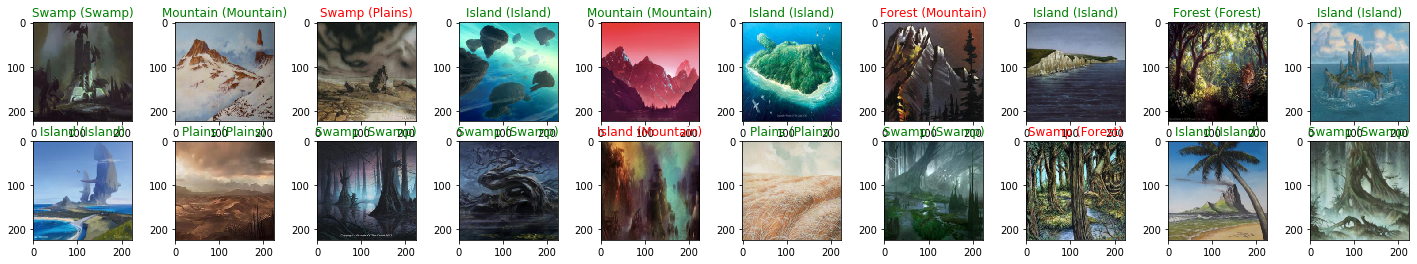

In [14]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    dataiter = iter(validation_loader)
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(20):
        ax = fig.add_subplot(2, 10, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))


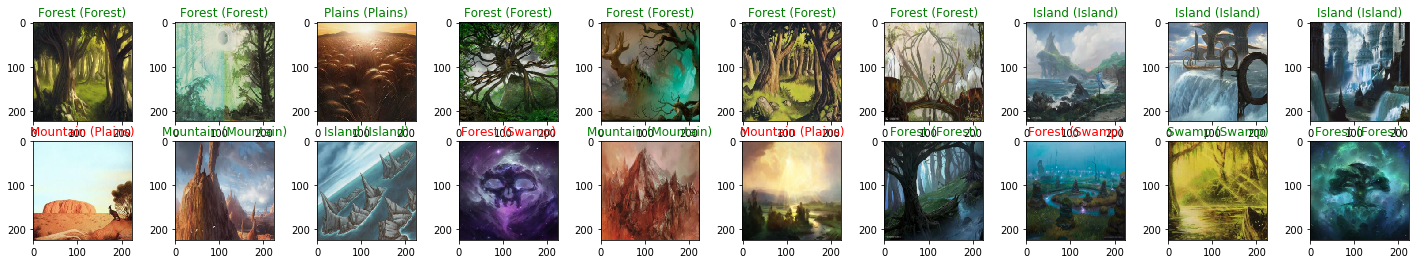

In [15]:
with torch.no_grad():
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(20):
        ax = fig.add_subplot(2, 10, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))


In [16]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

# get all the model children as list
model_children = list(model.children())
# counter to keep count of the conv layers
counter = 0

# append all the conv layers and their respective weights to the list
for i in range(len(model_children[0])):
    if type(model_children[0][i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[0][i].weight)
        conv_layers.append(model_children[0][i])
    elif type(model_children[0][i]) == nn.Sequential:
        for j in range(len(model_children[0][i])):
            for child in model_children[0][i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 10


In [17]:
"""
plt.figure(figsize=(220, 300))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu())
    plt.axis('off')
    plt.savefig('outputs/filter_' + str(i) + '.png')
plt.show()
"""

"\nplt.figure(figsize=(220, 300))\nfor i, filter in enumerate(model_weights[0]):\n    plt.subplot(4, 4, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)\n    plt.imshow(filter[0, :, :].detach().cpu())\n    plt.axis('off')\n    plt.savefig('outputs/filter_' + str(i) + '.png')\nplt.show()\n"

In [18]:
if len(conv_layers) > 0:
    model.eval()
    dataiter = iter(validation_loader)
    images, labels = dataiter.next()
    gpu_images = images.to(device)
    img = gpu_images[3].unsqueeze(0)

    # pass the image through all the layers
    results = [conv_layers[0](img)]
    for i in range(1, len(conv_layers)):
        # pass the result from the last layer to the next layer
        results.append(conv_layers[i](results[-1]))

    # make a copy of the `results`
    outputs = results
else:
    outputs = []

In [19]:
if len(outputs) > 0:
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(44, 60))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print(layer_viz.size())
        for i, filter in enumerate(layer_viz):
            if i == 100: # we will visualize only 8x8 blocks from each layer
                break
            plt.subplot(10, 10, i + 1)
            plt.imshow(filter.cpu(), cmap='gray')
            plt.axis("off")
        print(f"Saving layer {num_layer} feature maps...")
        plt.savefig(f"outputs/layer_{num_layer}.png")
        # plt.show()
        plt.close()


torch.Size([64, 224, 224])
Saving layer 0 feature maps...
torch.Size([64, 224, 224])
Saving layer 1 feature maps...
torch.Size([128, 224, 224])
Saving layer 2 feature maps...
torch.Size([128, 224, 224])
Saving layer 3 feature maps...
torch.Size([256, 224, 224])
Saving layer 4 feature maps...
torch.Size([256, 224, 224])
Saving layer 5 feature maps...
torch.Size([512, 224, 224])
Saving layer 6 feature maps...
torch.Size([512, 224, 224])
Saving layer 7 feature maps...
torch.Size([512, 224, 224])
Saving layer 8 feature maps...
torch.Size([512, 224, 224])
Saving layer 9 feature maps...
